# Bird Call Data Processing

In [1]:
import os
import pandas as pd
import json
import urllib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import subprocess
import scipy.io.wavfile as wf
import scipy.signal as sg
import scipy.ndimage as sn
import time
import math
import skimage.measure as sm
import random
import pickle
import re

In [8]:
checklistdir = '/home/dphogan/data_science/species_list'
namesonlyfile = 'common_birds.csv'
namesonlypath = os.path.join(checklistdir, namesonlyfile)
namespremixfile = 'common_birds_premix.csv'
namespremixpath = os.path.join(checklistdir, namespremixfile)
namescountsfile = 'common_birds_numfiles.csv'
namescountspath = os.path.join(checklistdir, namescountsfile)
chirpfile = 'chirp_table.csv'
chirppath = os.path.join(checklistdir, chirpfile)
labelsfile = 'labels.csv'
labelspath = os.path.join(checklistdir, labelsfile)
labelsverbosefile = 'labelsverbose.csv'
labelsverbosepath = os.path.join(checklistdir, labelsverbosefile)
datafile = 'traintestvalid.p'
datapath = os.path.join(checklistdir, datafile)
localmp3dir = '/home/dphogan/data_science/data/xc_mp3'
tempfilepath = '/home/dphogan/data_science/data/temp.wav'
birdphotodir = '/home/dphogan/data_science/data/bird_photos'
birdphoto2dir = '/home/dphogan/data_science/data/bird_photos_used'
spectrogramdir = '/home/dphogan/data_science/data/spectrogram_arrays'

### Getting ID numbers

In [63]:
#Count how many recordings of each bird species there are, and save the resulting CSV
#First, read original bird list
df = pd.read_csv(namesonlypath)
df.head()

,molabel,common name,scientific name,genus,species,codes
0,3,Snow Goose,Anser caerulescens,Anser,caerulescens,WR c (local); SV r; SR a (nw)
1,5,Greater White-fronted Goose,Anser albifrons,Anser,albifrons,T c; WR u; SV ca
2,8,Cackling Goose,Branta hutchinsii,Branta,hutchinsii,"T c (w), u (e); WR u"
3,9,Canada Goose,Branta canadensis,Branta,canadensis,PR c
4,13,Wood Duck,Aix sponsa,Aix,sponsa,"SR c; WR u (se), r (elsewhere)"


In [64]:
#Get the xeno-canto ID numbers for each bird species
df.insert(5,'numrecordings', 0, allow_duplicates=True)
df.insert(6,'ids', 0, allow_duplicates=True)
df = df.astype(object)
for i in range(len(df.index)):
    idlist = []
    df.at[i,'ids'] = idlist
for i in range(len(df.index)):
    genus = df.loc[i, 'genus']
    species = df.loc[i, 'species']
    speciesurl = 'https://www.xeno-canto.org/api/2/recordings?query=' + genus + '%20' + species
    print(speciesurl)
    response = urllib.request.urlopen(speciesurl)
    result = json.load(response)
    df.loc[i, 'numrecordings'] = int(result['numRecordings'])
    for entry in result['recordings']:
        id = int(entry['id'])
        df.loc[i, 'ids'].append(id)
    if i==0-1:
        break
df.to_csv(namespremixpath)

https://www.xeno-canto.org/api/2/recordings?query=Anser%20caerulescens
https://www.xeno-canto.org/api/2/recordings?query=Anser%20albifrons
https://www.xeno-canto.org/api/2/recordings?query=Branta%20hutchinsii
https://www.xeno-canto.org/api/2/recordings?query=Branta%20canadensis
https://www.xeno-canto.org/api/2/recordings?query=Aix%20sponsa
https://www.xeno-canto.org/api/2/recordings?query=Anas%20discors
https://www.xeno-canto.org/api/2/recordings?query=Anas%20clypeata
https://www.xeno-canto.org/api/2/recordings?query=Anas%20strepera
https://www.xeno-canto.org/api/2/recordings?query=Anas%20americana
https://www.xeno-canto.org/api/2/recordings?query=Anas%20platyrhynchos
https://www.xeno-canto.org/api/2/recordings?query=Anas%20acuta
https://www.xeno-canto.org/api/2/recordings?query=Anas%20crecca
https://www.xeno-canto.org/api/2/recordings?query=Aythya%20valisineria
https://www.xeno-canto.org/api/2/recordings?query=Aythya%20collaris
https://www.xeno-canto.org/api/2/recordings?query=Aythya%

https://www.xeno-canto.org/api/2/recordings?query=Toxostoma%20rufum
https://www.xeno-canto.org/api/2/recordings?query=Mimus%20polyglottos
https://www.xeno-canto.org/api/2/recordings?query=Sturnus%20vulgaris
https://www.xeno-canto.org/api/2/recordings?query=Bombycilla%20cedrorum
https://www.xeno-canto.org/api/2/recordings?query=Passer%20domesticus
https://www.xeno-canto.org/api/2/recordings?query=Passer%20montanus
https://www.xeno-canto.org/api/2/recordings?query=Anthus%20rubescens
https://www.xeno-canto.org/api/2/recordings?query=Haemorhous%20purpureus
https://www.xeno-canto.org/api/2/recordings?query=Spinus%20tristis
https://www.xeno-canto.org/api/2/recordings?query=Calcarius%20lapponicus
https://www.xeno-canto.org/api/2/recordings?query=Pipilo%20erythrophthalmus
https://www.xeno-canto.org/api/2/recordings?query=Spizelloides%20arborea
https://www.xeno-canto.org/api/2/recordings?query=Spizella%20passerina
https://www.xeno-canto.org/api/2/recordings?query=Spizella%20pusilla
https://www.

In [65]:
dforig = df
print('Total birds: %i' % len(df))
df.head()

Total birds: 184


,molabel,common name,scientific name,genus,species,numrecordings,ids,codes
0,3,Snow Goose,Anser caerulescens,Anser,caerulescens,66,"[393000, 392250, 392249, 408863, 393551, 39354...",WR c (local); SV r; SR a (nw)
1,5,Greater White-fronted Goose,Anser albifrons,Anser,albifrons,157,"[424446, 424445, 424444, 424443, 405451, 40544...",T c; WR u; SV ca
2,8,Cackling Goose,Branta hutchinsii,Branta,hutchinsii,35,"[406173, 361080, 354744, 320750, 320749, 32074...","T c (w), u (e); WR u"
3,9,Canada Goose,Branta canadensis,Branta,canadensis,250,"[432880, 429108, 424354, 420861, 415068, 43513...",PR c
4,13,Wood Duck,Aix sponsa,Aix,sponsa,47,"[379663, 389582, 356971, 347194, 332246, 18295...","SR c; WR u (se), r (elsewhere)"


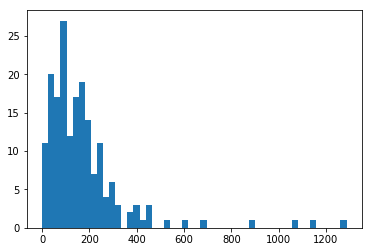

In [66]:
counts = [x for x in df['numrecordings']]
n,bins,patches = plt.hist(counts, bins=50)

### Randomize Recordings

In [67]:
#First, load in data from the saved file
df = pd.read_csv(namespremixpath, index_col=0)
#Then, fix the integer arrays getting cast to strings
for i in range(len(df.index)):
    idlist = df.at[i,'ids']
    if idlist=='[]':
        df.at[i,'ids'] = []
    else:
        df.at[i,'ids'] = [int(x) for x in idlist[1:-1].split(', ')]

In [68]:
#Shuffle the recordings
for i in range(len(df.index)):
    idlist = df.at[i,'ids']
    random.shuffle(df.at[i,'ids'])
df.head()
df.to_csv(namescountspath)

### Getting Files

In [97]:
#First, load in data from the saved file
df = pd.read_csv(namescountspath, index_col=0)
#Then, fix the integer arrays getting cast to strings
for i in range(len(df.index)):
    idlist = df.at[i,'ids']
    if idlist=='[]':
        df.at[i,'ids'] = []
    else:
        df.at[i,'ids'] = [int(x) for x in idlist[1:-1].split(', ')]

In [99]:
#Then, download recordings
maxperbird = 250
minperbird = 50
starttime = time.time()
notfound = []
for birdindex in range(len(df.index)):
    print('%i. %s' % (birdindex+1,df.at[birdindex,'common name']))
    ids = df.at[birdindex,'ids']
    if len(ids)<minperbird:
        print('Insufficient recordings to use.')
        continue
    for recordingindex in range(min(len(ids),maxperbird)):
        id = str(ids[recordingindex])
        sourcepath = 'https://www.xeno-canto.org/' + id + '/download'
        destinationfile = id + '.mp3'
        destinationpath = os.path.join(localmp3dir, destinationfile)
        if not os.path.exists(destinationpath):
            print('   Downloading file ID '+id)
            try:
                urllib.request.urlretrieve(sourcepath, destinationpath)
            except urllib.error.HTTPError:
                print('!!!File not found: ID '+id)
                notfound.append(id)
        else:
            print('   Already downloaded file ID '+id)
endtime = time.time()
print('Time: %.2f min' % ((endtime-starttime)/60) )
print('Files not found:')
print(notfound)

1. Snow Goose
   Already downloaded file ID 173139
   Already downloaded file ID 392250
   Already downloaded file ID 220922
   Already downloaded file ID 149944
   Already downloaded file ID 342562
   Already downloaded file ID 220921
   Already downloaded file ID 160502
   Already downloaded file ID 220925
   Already downloaded file ID 116051
   Already downloaded file ID 143620
   Already downloaded file ID 140021
   Already downloaded file ID 393551
   Already downloaded file ID 220923
   Already downloaded file ID 393000
   Already downloaded file ID 29368
   Already downloaded file ID 160490
   Already downloaded file ID 92035
   Already downloaded file ID 435999
   Already downloaded file ID 408863
   Already downloaded file ID 28265
   Already downloaded file ID 143621
   Already downloaded file ID 160423
   Already downloaded file ID 143617
   Already downloaded file ID 220926
   Already downloaded file ID 115925
   Already downloaded file ID 392249
   Already downloaded file 

   Already downloaded file ID 262851
   Already downloaded file ID 406499
   Already downloaded file ID 197026
   Already downloaded file ID 113967
   Already downloaded file ID 395840
   Already downloaded file ID 212804
   Already downloaded file ID 412763
   Already downloaded file ID 263945
   Already downloaded file ID 374889
   Already downloaded file ID 124991
   Already downloaded file ID 83444
   Already downloaded file ID 171891
   Already downloaded file ID 432261
   Already downloaded file ID 307723
   Already downloaded file ID 294834
   Already downloaded file ID 340594
   Already downloaded file ID 216865
   Already downloaded file ID 76788
   Already downloaded file ID 161957
   Already downloaded file ID 107298
   Already downloaded file ID 300911
   Already downloaded file ID 266792
   Already downloaded file ID 412525
   Already downloaded file ID 128954
   Already downloaded file ID 377959
   Already downloaded file ID 266791
   Already downloaded file ID 190744
   

   Already downloaded file ID 408534
   Already downloaded file ID 51135
   Already downloaded file ID 287249
   Already downloaded file ID 321525
   Already downloaded file ID 103478
   Already downloaded file ID 54527
   Already downloaded file ID 370849
   Already downloaded file ID 394743
   Already downloaded file ID 206177
   Already downloaded file ID 11629
   Already downloaded file ID 51136
   Already downloaded file ID 349622
   Already downloaded file ID 113810
   Already downloaded file ID 5779
   Already downloaded file ID 113811
   Already downloaded file ID 45438
   Already downloaded file ID 11510
23. Rock Pigeon
   Already downloaded file ID 257592
   Already downloaded file ID 10112
   Already downloaded file ID 194176
   Already downloaded file ID 296219
   Already downloaded file ID 197468
   Already downloaded file ID 412827
   Already downloaded file ID 129886
   Already downloaded file ID 121680
   Already downloaded file ID 70084
   Already downloaded file ID 51

   Already downloaded file ID 174366
   Already downloaded file ID 28271
   Already downloaded file ID 28270
   Already downloaded file ID 114340
   Already downloaded file ID 310065
   Already downloaded file ID 179975
   Already downloaded file ID 237512
   Already downloaded file ID 330688
   Already downloaded file ID 379011
   Already downloaded file ID 111114
   Already downloaded file ID 333614
   Already downloaded file ID 159119
   Already downloaded file ID 303505
   Already downloaded file ID 159792
   Already downloaded file ID 159135
   Already downloaded file ID 320700
   Already downloaded file ID 375908
   Already downloaded file ID 34584
   Already downloaded file ID 120845
   Already downloaded file ID 114341
   Already downloaded file ID 315528
   Already downloaded file ID 357960
   Already downloaded file ID 379009
   Already downloaded file ID 359349
   Already downloaded file ID 215682
   Already downloaded file ID 201404
   Already downloaded file ID 330228
   A

   Already downloaded file ID 87087
   Already downloaded file ID 17829
   Already downloaded file ID 17507
   Already downloaded file ID 147358
   Already downloaded file ID 268819
   Already downloaded file ID 145676
   Already downloaded file ID 190804
   Already downloaded file ID 34829
   Already downloaded file ID 220050
   Already downloaded file ID 33269
   Already downloaded file ID 203718
   Already downloaded file ID 267510
   Already downloaded file ID 257530
   Already downloaded file ID 203720
   Already downloaded file ID 332336
   Already downloaded file ID 147360
   Already downloaded file ID 318471
   Already downloaded file ID 203719
   Already downloaded file ID 107608
   Already downloaded file ID 220056
   Already downloaded file ID 76511
   Already downloaded file ID 15215
   Already downloaded file ID 257532
   Already downloaded file ID 109318
   Already downloaded file ID 106043
   Already downloaded file ID 109320
   Already downloaded file ID 109319
   Alrea

   Already downloaded file ID 321384
   Already downloaded file ID 270544
   Already downloaded file ID 319718
   Already downloaded file ID 53495
   Already downloaded file ID 109329
   Already downloaded file ID 183594
   Already downloaded file ID 322582
   Already downloaded file ID 389435
   Already downloaded file ID 308827
   Already downloaded file ID 278363
   Already downloaded file ID 254627
   Already downloaded file ID 330062
   Already downloaded file ID 257520
   Already downloaded file ID 287590
   Already downloaded file ID 325949
   Already downloaded file ID 213494
   Already downloaded file ID 391160
   Already downloaded file ID 139790
   Already downloaded file ID 391149
   Already downloaded file ID 113387
   Already downloaded file ID 422425
   Already downloaded file ID 139722
   Already downloaded file ID 58489
   Already downloaded file ID 31323
   Already downloaded file ID 232640
   Already downloaded file ID 53496
   Already downloaded file ID 334369
   Al

   Already downloaded file ID 187422
   Already downloaded file ID 53240
   Already downloaded file ID 237429
   Already downloaded file ID 16399
   Already downloaded file ID 413365
   Already downloaded file ID 150345
   Already downloaded file ID 42317
   Already downloaded file ID 53239
   Already downloaded file ID 108204
   Already downloaded file ID 57682
   Already downloaded file ID 306694
   Already downloaded file ID 412027
   Already downloaded file ID 16592
   Already downloaded file ID 247287
   Already downloaded file ID 427766
   Already downloaded file ID 45893
   Already downloaded file ID 45892
   Already downloaded file ID 403219
   Already downloaded file ID 108205
   Already downloaded file ID 92277
   Already downloaded file ID 57681
   Already downloaded file ID 45890
   Already downloaded file ID 57686
56. Double-crested Cormorant
Insufficient recordings to use.
57. American White Pelican
Insufficient recordings to use.
58. Great Blue Heron
   Already downloade

   Already downloaded file ID 387371
   Already downloaded file ID 283405
   Already downloaded file ID 138060
   Already downloaded file ID 151692
   Already downloaded file ID 376755
   Already downloaded file ID 342574
   Already downloaded file ID 298138
   Already downloaded file ID 411847
   Already downloaded file ID 347525
   Already downloaded file ID 351290
   Already downloaded file ID 113807
   Already downloaded file ID 335480
   Already downloaded file ID 391578
   Already downloaded file ID 138061
   Already downloaded file ID 312451
   Already downloaded file ID 199896
   Already downloaded file ID 74890
   Already downloaded file ID 432233
   Already downloaded file ID 66179
   Already downloaded file ID 289380
   Already downloaded file ID 30457
   Already downloaded file ID 332643
   Already downloaded file ID 404798
   Already downloaded file ID 335217
   Already downloaded file ID 154990
   Already downloaded file ID 100720
   Already downloaded file ID 15430
   Al

   Already downloaded file ID 341005
   Already downloaded file ID 53405
   Already downloaded file ID 53346
   Already downloaded file ID 12219
   Already downloaded file ID 289032
   Already downloaded file ID 53349
   Already downloaded file ID 14710
   Already downloaded file ID 431030
   Already downloaded file ID 6491
   Already downloaded file ID 51475
   Already downloaded file ID 254589
   Already downloaded file ID 418510
   Already downloaded file ID 72027
   Already downloaded file ID 297550
   Already downloaded file ID 53351
   Already downloaded file ID 50661
   Already downloaded file ID 213165
   Already downloaded file ID 16111
   Already downloaded file ID 253951
   Already downloaded file ID 53350
   Already downloaded file ID 250844
   Already downloaded file ID 216657
   Already downloaded file ID 308302
   Already downloaded file ID 223029
   Already downloaded file ID 138718
   Already downloaded file ID 56416
   Already downloaded file ID 419402
   Already down

   Already downloaded file ID 215904
   Already downloaded file ID 215911
   Already downloaded file ID 135455
   Already downloaded file ID 157462
   Already downloaded file ID 374638
   Already downloaded file ID 135456
   Already downloaded file ID 134932
   Already downloaded file ID 189592
   Already downloaded file ID 247799
   Already downloaded file ID 216284
   Already downloaded file ID 167791
   Already downloaded file ID 215905
   Already downloaded file ID 16966
   Already downloaded file ID 13755
   Already downloaded file ID 31209
   Already downloaded file ID 247801
   Already downloaded file ID 406251
   Already downloaded file ID 216222
   Already downloaded file ID 323016
   Already downloaded file ID 188813
   Already downloaded file ID 144099
   Already downloaded file ID 370932
   Already downloaded file ID 370826
   Already downloaded file ID 216219
   Already downloaded file ID 253936
   Already downloaded file ID 216216
   Already downloaded file ID 232634
   A

   Already downloaded file ID 277334
   Already downloaded file ID 385659
   Already downloaded file ID 336992
   Already downloaded file ID 390596
   Already downloaded file ID 310198
   Already downloaded file ID 139505
   Already downloaded file ID 381585
   Already downloaded file ID 253857
   Already downloaded file ID 382347
   Already downloaded file ID 357977
   Already downloaded file ID 149318
   Already downloaded file ID 190440
   Already downloaded file ID 149308
   Already downloaded file ID 164548
   Already downloaded file ID 385658
   Already downloaded file ID 98814
   Already downloaded file ID 168094
   Already downloaded file ID 53397
   Already downloaded file ID 167954
   Already downloaded file ID 296398
   Already downloaded file ID 173280
   Already downloaded file ID 418322
   Already downloaded file ID 356493
   Already downloaded file ID 370249
   Already downloaded file ID 139930
   Already downloaded file ID 370941
   Already downloaded file ID 110056
   

   Already downloaded file ID 278199
   Already downloaded file ID 33565
   Already downloaded file ID 108734
   Already downloaded file ID 164748
   Already downloaded file ID 253355
   Already downloaded file ID 176376
   Already downloaded file ID 59092
   Already downloaded file ID 135668
   Already downloaded file ID 196882
   Already downloaded file ID 320111
   Already downloaded file ID 433224
96. Tree Swallow
   Already downloaded file ID 408096
   Already downloaded file ID 256197
   Already downloaded file ID 323053
   Already downloaded file ID 212619
   Already downloaded file ID 132146
   Already downloaded file ID 175270
   Already downloaded file ID 134156
   Already downloaded file ID 163175
   Already downloaded file ID 115820
   Already downloaded file ID 184629
   Already downloaded file ID 163169
   Already downloaded file ID 163172
   Already downloaded file ID 357947
   Already downloaded file ID 312721
   Already downloaded file ID 81094
   Already downloaded fi

   Already downloaded file ID 296930
   Already downloaded file ID 234671
   Already downloaded file ID 173453
   Already downloaded file ID 70981
   Already downloaded file ID 326922
   Already downloaded file ID 357982
   Already downloaded file ID 173457
   Already downloaded file ID 121933
   Already downloaded file ID 52990
   Already downloaded file ID 232860
   Already downloaded file ID 209081
   Already downloaded file ID 18446
   Already downloaded file ID 173459
   Already downloaded file ID 358104
   Already downloaded file ID 97243
   Already downloaded file ID 138604
   Already downloaded file ID 79586
   Already downloaded file ID 97249
   Already downloaded file ID 358096
   Already downloaded file ID 358105
   Already downloaded file ID 227271
   Already downloaded file ID 112633
   Already downloaded file ID 70979
   Already downloaded file ID 391432
   Already downloaded file ID 15190
   Already downloaded file ID 15189
   Already downloaded file ID 18445
   Already 

   Already downloaded file ID 21291
   Already downloaded file ID 252947
   Already downloaded file ID 292279
   Already downloaded file ID 114591
   Already downloaded file ID 86754
   Already downloaded file ID 240533
   Already downloaded file ID 350799
   Already downloaded file ID 213896
   Already downloaded file ID 301024
   Already downloaded file ID 54710
   Already downloaded file ID 350800
   Already downloaded file ID 295476
   Already downloaded file ID 395414
   Already downloaded file ID 287563
   Already downloaded file ID 335423
   Already downloaded file ID 233937
   Already downloaded file ID 331394
   Already downloaded file ID 306138
   Already downloaded file ID 121453
   Already downloaded file ID 397331
   Already downloaded file ID 348600
   Already downloaded file ID 298589
   Already downloaded file ID 321970
   Already downloaded file ID 321968
   Already downloaded file ID 350816
   Already downloaded file ID 14549
   Already downloaded file ID 435737
   Al

   Already downloaded file ID 62954
   Already downloaded file ID 23667
   Already downloaded file ID 100674
   Already downloaded file ID 15495
   Already downloaded file ID 266047
   Already downloaded file ID 180301
   Already downloaded file ID 6277
   Already downloaded file ID 385130
   Already downloaded file ID 221128
   Already downloaded file ID 15450
   Already downloaded file ID 414172
   Already downloaded file ID 379342
   Already downloaded file ID 221139
   Already downloaded file ID 184610
   Already downloaded file ID 107078
   Already downloaded file ID 326402
   Already downloaded file ID 52637
   Already downloaded file ID 37972
   Already downloaded file ID 50196
   Already downloaded file ID 296518
   Already downloaded file ID 296517
   Already downloaded file ID 221129
   Already downloaded file ID 345636
   Already downloaded file ID 100675
   Already downloaded file ID 130351
   Already downloaded file ID 328511
   Already downloaded file ID 78333
   Already 

   Already downloaded file ID 376229
   Already downloaded file ID 228487
   Already downloaded file ID 253947
   Already downloaded file ID 14876
   Already downloaded file ID 168753
   Already downloaded file ID 174838
   Already downloaded file ID 317245
   Already downloaded file ID 360371
   Already downloaded file ID 263484
   Already downloaded file ID 315294
   Already downloaded file ID 331769
   Already downloaded file ID 314950
   Already downloaded file ID 21470
   Already downloaded file ID 417910
   Already downloaded file ID 1218
   Already downloaded file ID 136278
   Already downloaded file ID 228488
   Already downloaded file ID 174760
   Already downloaded file ID 416548
110. Golden-crowned Kinglet
   Already downloaded file ID 103079
   Already downloaded file ID 135594
   Already downloaded file ID 336955
   Already downloaded file ID 391427
   Already downloaded file ID 351797
   Already downloaded file ID 189977
   Already downloaded file ID 99383
   Already down

   Already downloaded file ID 193963
   Already downloaded file ID 220625
   Already downloaded file ID 177886
   Already downloaded file ID 210696
   Already downloaded file ID 185531
   Already downloaded file ID 129847
   Already downloaded file ID 195593
   Already downloaded file ID 292466
   Already downloaded file ID 101353
   Already downloaded file ID 330878
   Already downloaded file ID 195577
   Already downloaded file ID 101355
   Already downloaded file ID 355206
   Already downloaded file ID 160832
   Already downloaded file ID 193967
   Already downloaded file ID 355193
   Already downloaded file ID 35307
   Already downloaded file ID 206692
   Already downloaded file ID 416082
   Already downloaded file ID 417367
   Already downloaded file ID 377031
   Already downloaded file ID 264250
   Already downloaded file ID 144680
   Already downloaded file ID 322994
   Already downloaded file ID 101436
   Already downloaded file ID 323001
   Already downloaded file ID 63227
   

   Already downloaded file ID 371321
   Already downloaded file ID 165285
   Already downloaded file ID 186427
   Already downloaded file ID 233944
   Already downloaded file ID 172423
   Already downloaded file ID 78015
   Already downloaded file ID 313434
   Already downloaded file ID 163143
   Already downloaded file ID 57211
   Already downloaded file ID 383961
   Already downloaded file ID 107523
   Already downloaded file ID 158993
   Already downloaded file ID 165299
   Already downloaded file ID 131877
   Already downloaded file ID 129105
   Already downloaded file ID 160115
   Already downloaded file ID 301682
   Already downloaded file ID 302644
   Already downloaded file ID 83722
   Already downloaded file ID 153866
   Already downloaded file ID 322572
   Already downloaded file ID 322566
   Already downloaded file ID 353375
   Already downloaded file ID 160026
   Already downloaded file ID 153633
   Already downloaded file ID 160308
   Already downloaded file ID 129802
   A

   Already downloaded file ID 37652
   Already downloaded file ID 131645
   Already downloaded file ID 363168
   Already downloaded file ID 343247
   Already downloaded file ID 291918
   Already downloaded file ID 421284
   Already downloaded file ID 169237
   Already downloaded file ID 372199
   Already downloaded file ID 140981
   Already downloaded file ID 413151
   Already downloaded file ID 65794
   Already downloaded file ID 314414
   Already downloaded file ID 361006
   Already downloaded file ID 393132
   Already downloaded file ID 135078
   Already downloaded file ID 216848
   Already downloaded file ID 408581
   Already downloaded file ID 420964
   Already downloaded file ID 190455
   Already downloaded file ID 305407
   Already downloaded file ID 321881
   Already downloaded file ID 253514
   Already downloaded file ID 90143
   Already downloaded file ID 405612
   Already downloaded file ID 121797
   Already downloaded file ID 307481
   Already downloaded file ID 428497
   A

   Already downloaded file ID 156529
   Already downloaded file ID 159713
   Already downloaded file ID 227791
   Already downloaded file ID 30888
   Already downloaded file ID 159074
   Already downloaded file ID 135083
   Already downloaded file ID 139760
   Already downloaded file ID 298971
   Already downloaded file ID 195202
   Already downloaded file ID 160217
   Already downloaded file ID 133995
   Already downloaded file ID 393245
   Already downloaded file ID 13179
   Already downloaded file ID 161662
   Already downloaded file ID 288221
   Already downloaded file ID 99381
   Already downloaded file ID 167977
   Already downloaded file ID 65941
   Already downloaded file ID 160238
   Already downloaded file ID 153880
   Already downloaded file ID 335874
   Already downloaded file ID 341484
   Already downloaded file ID 160553
   Already downloaded file ID 159070
   Already downloaded file ID 190126
   Already downloaded file ID 160311
   Already downloaded file ID 159056
   Al

   Already downloaded file ID 305164
   Already downloaded file ID 368742
   Already downloaded file ID 320484
   Already downloaded file ID 428878
   Already downloaded file ID 276991
   Already downloaded file ID 137047
   Already downloaded file ID 328195
   Already downloaded file ID 31287
   Already downloaded file ID 410054
   Already downloaded file ID 404833
   Already downloaded file ID 216767
   Already downloaded file ID 215914
   Already downloaded file ID 33778
   Already downloaded file ID 320442
   Already downloaded file ID 98404
   Already downloaded file ID 145787
   Already downloaded file ID 430295
   Already downloaded file ID 138135
   Already downloaded file ID 97245
   Already downloaded file ID 320489
   Already downloaded file ID 179558
   Already downloaded file ID 388583
   Already downloaded file ID 190528
   Already downloaded file ID 109895
   Already downloaded file ID 263726
   Already downloaded file ID 362472
   Already downloaded file ID 103812
   Al

   Already downloaded file ID 370938
   Already downloaded file ID 320482
   Already downloaded file ID 313155
   Already downloaded file ID 277218
   Already downloaded file ID 327919
   Already downloaded file ID 416557
   Already downloaded file ID 288987
   Already downloaded file ID 179707
   Already downloaded file ID 429248
   Already downloaded file ID 373696
   Already downloaded file ID 125236
   Already downloaded file ID 322491
   Already downloaded file ID 126079
   Already downloaded file ID 155240
   Already downloaded file ID 338491
   Already downloaded file ID 86488
   Already downloaded file ID 83513
   Already downloaded file ID 21044
   Already downloaded file ID 31017
   Already downloaded file ID 366699
   Already downloaded file ID 107573
   Already downloaded file ID 83421
   Already downloaded file ID 229855
   Already downloaded file ID 396110
   Already downloaded file ID 107454
   Already downloaded file ID 237276
   Already downloaded file ID 144652
   Alr

   Already downloaded file ID 192251
   Already downloaded file ID 421834
   Already downloaded file ID 416329
   Already downloaded file ID 89166
   Already downloaded file ID 399784
   Already downloaded file ID 307663
136. Song Sparrow
   Already downloaded file ID 408443
   Already downloaded file ID 158957
   Already downloaded file ID 315071
   Already downloaded file ID 103204
   Already downloaded file ID 429249
   Already downloaded file ID 191448
   Already downloaded file ID 415426
   Already downloaded file ID 246812
   Already downloaded file ID 153555
   Already downloaded file ID 142716
   Already downloaded file ID 297670
   Already downloaded file ID 369683
   Already downloaded file ID 364403
   Already downloaded file ID 306941
   Already downloaded file ID 408857
   Already downloaded file ID 420592
   Already downloaded file ID 111648
   Already downloaded file ID 310927
   Already downloaded file ID 406666
   Already downloaded file ID 366606
   Already downloaded

   Already downloaded file ID 65373
   Already downloaded file ID 111738
   Already downloaded file ID 325005
   Already downloaded file ID 316142
   Already downloaded file ID 159489
   Already downloaded file ID 277701
   Already downloaded file ID 207793
   Already downloaded file ID 177468
   Already downloaded file ID 369977
   Already downloaded file ID 393304
   Already downloaded file ID 349732
   Already downloaded file ID 111290
   Already downloaded file ID 160091
   Already downloaded file ID 354510
   Already downloaded file ID 159230
   Already downloaded file ID 254425
   Already downloaded file ID 41863
   Already downloaded file ID 289378
   Already downloaded file ID 283187
   Already downloaded file ID 349733
   Already downloaded file ID 111753
   Already downloaded file ID 70498
   Already downloaded file ID 253829
   Already downloaded file ID 103312
   Already downloaded file ID 21286
   Already downloaded file ID 1396
   Already downloaded file ID 158955
   Alre

   Already downloaded file ID 372034
   Already downloaded file ID 185825
   Already downloaded file ID 325469
   Already downloaded file ID 256623
   Already downloaded file ID 170899
   Already downloaded file ID 356611
   Already downloaded file ID 371784
   Already downloaded file ID 185142
   Already downloaded file ID 418020
   Already downloaded file ID 367439
   Already downloaded file ID 355287
   Already downloaded file ID 332656
   Already downloaded file ID 368629
   Already downloaded file ID 355377
   Already downloaded file ID 355387
   Already downloaded file ID 355305
   Already downloaded file ID 355389
   Already downloaded file ID 186330
   Already downloaded file ID 355300
   Already downloaded file ID 184990
   Already downloaded file ID 185140
   Already downloaded file ID 355271
   Already downloaded file ID 1291
   Already downloaded file ID 210104
   Already downloaded file ID 355360
   Already downloaded file ID 362530
   Already downloaded file ID 253536
   

   Already downloaded file ID 196112
   Already downloaded file ID 57034
   Already downloaded file ID 184886
   Already downloaded file ID 294519
   Already downloaded file ID 325907
   Already downloaded file ID 184891
   Already downloaded file ID 286426
   Already downloaded file ID 160393
   Already downloaded file ID 99545
   Already downloaded file ID 345872
   Already downloaded file ID 186660
   Already downloaded file ID 320236
   Already downloaded file ID 75624
   Already downloaded file ID 197286
   Already downloaded file ID 316288
   Already downloaded file ID 20559
   Already downloaded file ID 18480
   Already downloaded file ID 282300
   Already downloaded file ID 131089
   Already downloaded file ID 176279
   Already downloaded file ID 70005
   Already downloaded file ID 160288
   Already downloaded file ID 362247
   Already downloaded file ID 196109
   Already downloaded file ID 176405
   Already downloaded file ID 160397
   Already downloaded file ID 79612
   Alrea

!!!File not found: ID 154082
   Already downloaded file ID 313870
   Already downloaded file ID 131878
   Already downloaded file ID 147865
   Already downloaded file ID 81061
   Already downloaded file ID 309889
   Already downloaded file ID 143748
   Already downloaded file ID 122252
   Already downloaded file ID 141412
   Already downloaded file ID 49549
   Already downloaded file ID 244525
   Already downloaded file ID 87445
   Already downloaded file ID 100548
   Already downloaded file ID 131879
   Already downloaded file ID 76678
   Already downloaded file ID 367253
   Already downloaded file ID 78654
   Already downloaded file ID 77263
   Already downloaded file ID 87444
   Already downloaded file ID 334686
158. Prothonotary Warbler
   Already downloaded file ID 33466
   Already downloaded file ID 5560
   Already downloaded file ID 324897
   Already downloaded file ID 54330
   Already downloaded file ID 316226
   Already downloaded file ID 247828
   Already downloaded file ID 2

   Already downloaded file ID 330441
   Already downloaded file ID 404844
   Already downloaded file ID 100682
   Already downloaded file ID 134507
   Already downloaded file ID 253752
   Already downloaded file ID 101826
   Already downloaded file ID 195311
   Already downloaded file ID 20978
   Already downloaded file ID 101584
   Already downloaded file ID 373629
   Already downloaded file ID 243426
   Already downloaded file ID 244533
   Already downloaded file ID 301191
   Already downloaded file ID 389103
   Already downloaded file ID 361024
   Already downloaded file ID 83737
   Already downloaded file ID 368786
   Already downloaded file ID 269770
   Already downloaded file ID 179964
   Already downloaded file ID 15600
   Already downloaded file ID 245891
   Already downloaded file ID 315091
   Already downloaded file ID 296492
   Already downloaded file ID 419887
   Already downloaded file ID 70004
   Already downloaded file ID 31034
   Already downloaded file ID 368775
   Alr

   Already downloaded file ID 246836
   Already downloaded file ID 415385
   Already downloaded file ID 355509
   Already downloaded file ID 62708
   Already downloaded file ID 355508
   Already downloaded file ID 388842
   Already downloaded file ID 269074
   Already downloaded file ID 413021
   Already downloaded file ID 412808
   Already downloaded file ID 179215
   Already downloaded file ID 154970
   Already downloaded file ID 76155
   Already downloaded file ID 308307
   Already downloaded file ID 307228
   Already downloaded file ID 356397
   Already downloaded file ID 376084
   Already downloaded file ID 159319
   Already downloaded file ID 412928
   Already downloaded file ID 413019
   Already downloaded file ID 420276
   Already downloaded file ID 289662
   Already downloaded file ID 263059
   Already downloaded file ID 310952
   Already downloaded file ID 14193
   Already downloaded file ID 232264
   Already downloaded file ID 156187
   Already downloaded file ID 100602
   A

!!!File not found: ID 375269
   Already downloaded file ID 87763
   Already downloaded file ID 315709
   Already downloaded file ID 428401
   Already downloaded file ID 257145
   Already downloaded file ID 323221
   Already downloaded file ID 182156
   Already downloaded file ID 177093
   Already downloaded file ID 381738
   Already downloaded file ID 244067
   Already downloaded file ID 87762
   Already downloaded file ID 144033
   Already downloaded file ID 101746
   Already downloaded file ID 372201
   Already downloaded file ID 179560
   Already downloaded file ID 100581
   Already downloaded file ID 54750
180. Northern Cardinal
   Already downloaded file ID 317266
   Already downloaded file ID 70052
   Already downloaded file ID 434586
   Already downloaded file ID 211157
   Already downloaded file ID 190468
   Already downloaded file ID 285316
   Already downloaded file ID 86498
   Already downloaded file ID 130961
   Already downloaded file ID 1273
   Already downloaded file ID 

### Database of Pulses

Loop through the species, then through the recording for each one, building a new database of all pulses and numpy arrays for either deep learning or subsequent feature extraction for shallow learning.

In [3]:
def makemono(waveform):
    if len(np.shape(waveform))>1:
        return np.mean(waveform,axis=1)
    else:
        return waveform

In [4]:
def highpass(mono, samplerate):
    b = sg.firwin(101, cutoff=1000, fs=samplerate, pass_zero=False)
    filtered = sg.lfilter(b, [1.0], mono)
    return filtered

In [5]:
#Identify when the individual sounds start
#  marginfactor is ratio between cutoff and RMS
#  windowwidthtime is window duration in seconds
#  windowpretime is how much time to save before peak
#  windowfraction and windowfraction2 are the fraction of windowwidthtime that is tolerable under certain circumstances
def chirpstarts(mono, samplerate, marginfactor=2, windowwidthtime=4, windowpretime=.5, windowfraction=0.5, windowfraction2=0.25):
    times = [x/samplerate for x in range(len(mono))]
    
    #Find and mark cutoff
    rms = np.sqrt(np.mean(mono**2))
    cutoff = rms*math.sqrt(2)*marginfactor + np.mean(mono)
        
    #Find and mark chirp starts
    windowstartindices = []
    windowendindices = []
    windowstartindex = 0
    windowendindex = 0
    windowpeakindex = 0
    windownextlookindex = 0
    numpoints = len(mono)
    while windownextlookindex < numpoints:
        windowpeakindex = windownextlookindex + np.argmax(mono[windownextlookindex:]>cutoff)
        windowstartindex = max(0,int(windowpeakindex - windowpretime*samplerate))
        windowendindex = int(windowstartindex + windowwidthtime*samplerate)
        windownextlookindex = int(windowstartindex + (windowwidthtime+windowpretime)*samplerate)
        if windowendindex>=numpoints:
            if (numpoints-windowstartindex)/samplerate<windowfraction*windowwidthtime:
                break
            else:
                windowendindex = numpoints-1
        windowstartindices.append(windowstartindex)
        windowendindices.append(windowendindex)
    if len(windowstartindices)==0 and numpoints/samplerate>windowfraction2*windowwidthtime: #Deals with a special case where no pulse is found   
        windowstartindices = [windowstartindex]
        windowendindices = [numpoints-1]
    windowstarttimes = []
    windowendtimes = []
    for windowstartindex in windowstartindices:
        windowstarttimes.append(times[windowstartindex])
    for windowendindex in windowendindices:
        windowendtimes.append(times[windowendindex])
        
    return windowstartindices, windowendindices, windowstarttimes, windowendtimes, cutoff

In [6]:
#Given a spectrogram and its axis labels (f, t, s), and a time window and acquisition rate
#(mintime, maxtime, samplerate), calculate a downsampled spectrogram in that window 
#to serve as a medium-sized two-dimensional representation of the sound.
def computefingerprint(f, t, s, mintime, maxtime, samplerate):
    #Time cut
    condition = np.logical_and(t>=mintime, t<=maxtime)
    s = s[:,condition]
    t = t[condition]

    #Frequency cut
    condition = np.logical_and(f<=10000, f>=1000)
    s = s[condition,:]
    f = f[condition]
    
    #Use the logarithm of power spectral density
    floorterm = 1
    logs = np.log(s+floorterm)
    
    #Downsample.  Warning: Hard-coded numbers!
    idealsamplerate = 44100
    ftarget = 18
    ttarget = 158
    fblock = 3
    tblock = 5
    windowwidth = 4
    if samplerate == idealsamplerate:
        #In most common case, use fast downsampling
        sdown = sm.block_reduce(logs,(fblock,tblock),func=np.mean)
        fdown = f[::fblock]
        tdown = t[::tblock]
    else:
        #In other cases, use alternate downsampling
        ideallenf = ftarget
        ideallent = ttarget * (maxtime-mintime)/windowwidth
        sdown = sn.zoom(logs, (ideallenf/len(f), ideallent/len(t)))
        fdown = np.linspace(f[0],f[-1],ideallenf)
        tdown = np.linspace(t[0],t[-1],ideallent)
        samplerate = idealsamplerate

    #Cut or pad fingerprint, to ensure it's the exact right size
    sdown = sdown[:ftarget,:ttarget]
    fdown = fdown[:ftarget]
    tdown = tdown[:ttarget]
    sdown = np.pad(sdown, ((0,ftarget-np.shape(sdown)[0]),(0,ttarget-np.shape(sdown)[1])), 'constant', constant_values=0)
    fdown = np.linspace(f[0],f[-1],ftarget)
    tdown = np.linspace(t[0],t[0]+windowwidth,ttarget)
    #fdown = np.pad(fdown, (0,ftarget-np.shape(fdown)[0]), 'constant', constant_values=0)
    #tdown = np.pad(tdown, (0,ttarget-np.shape(tdown)[0]), 'constant', constant_values=0)
        
    #Plots (mostly for debugging)
    if False:
        plt.pcolor(t, f, logs)
        plt.colorbar()
        plt.show()
        plt.pcolor(tdown, fdown, sdown)
        plt.colorbar()
        plt.show()
        
    return sdown

In [7]:
#First, load in data from the saved file
df = pd.read_csv(namescountspath, index_col=0)
#Then, fix the integer arrays getting cast to strings
for i in range(len(df.index)):
    idlist = df.at[i,'ids']
    if idlist=='[]':
        df.at[i,'ids'] = []
    else:
        df.at[i,'ids'] = [int(x) for x in idlist[1:-1].split(', ')]

In [14]:
#Select birds to use
#dfselect = df[df['molabel'].isin([309, 428, 318, 269, 210, 215])] #Six example birds
#dfselect = df #All birds (note: even those with no recordings)
recordingmin = 50
#dfselect = df[df.apply(lambda x: len(x['ids'])>=recordingmin, axis=1)]
dfselect = df[df.apply(lambda x: len(x['ids'])>=recordingmin, axis=1) & (~df['molabel'].isin((255, 311, 390, 426))) ]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(dfselect)
print('Total entries: %i' % len(dfselect))
moselect = (dfselect['molabel']).to_csv(labelspath, header=True)
(dfselect.loc[:,['molabel','common name', 'scientific name', 'genus', 'species']]).to_csv(labelsverbosepath, header=True)

     molabel                   common name                scientific name  \
0          3                    Snow Goose             Anser caerulescens   
1          5   Greater White-fronted Goose                Anser albifrons   
3          9                  Canada Goose              Branta canadensis   
5         15              Blue-winged Teal                   Anas discors   
6         17             Northern Shoveler                  Anas clypeata   
7         18                       Gadwall                  Anas strepera   
9         21                       Mallard             Anas platyrhynchos   
11        25             Green-winged Teal                    Anas crecca   
15        37              Common Goldeneye             Bucephala clangula   
17        41              Common Merganser               Mergus merganser   
19        44             Northern Bobwhite            Colinus virginianus   
20        49                   Wild Turkey            Meleagris gallopavo   

In [16]:
#Create a table of all chirps, classified by testing/training/validation (cf="chirp frame")
#Also creates a file of spectrogram numpy arrays for each species.
recordingcount = 250

trainingfraction = 0.6
validationfraction = 0.2
testingfraction = 0.2

starttime = time.time()
totalrecordings = 0
trainingrecordings = 0
cf = pd.DataFrame(columns=["codestring", "molabel", "id", "chirpnum", "training", "testing", "validation", "unassigned"])
for bi in range(len(dfselect)):
    #Read in bird information, and check that bird hasn't already been processed
    birdrow = dfselect.iloc[bi]
    ids = birdrow['ids']
    numids = min(recordingcount, len(ids))
    totalrecordings += numids
    trainingrecordings += math.ceil(trainingfraction*numids)
    #continue
    filepath = os.path.join(spectrogramdir, birdrow['genus'] + '_' + birdrow['species'] + '.p')
    if os.path.exists(filepath):
        print('File already exists: %s' % filepath)
        continue
        
    #Tell code to restart building arrays
    trainstarted = False
    validstarted = False
    teststarted = False
    
    for (recordingnum, id) in enumerate(ids):
        if recordingnum==recordingcount:
            break
        print('%s %i' % (birdrow['common name'], recordingnum))
        
        #Assign this recording to a group
        trainingstatus = 0
        validationstatus = 0
        testingstatus = 0
        unassignedstatus = 0
        if recordingnum<trainingfraction*numids:
            trainingstatus = 1
        elif recordingnum<(trainingfraction+validationfraction)*numids:
            validationstatus = 1
        elif recordingnum<(trainingfraction+validationfraction+testingfraction)*numids:
            testingstatus = 1
        else:
            unassignedstatus = 1
        
        #Convert file from mp3 to wav
        sourcefile = str(id) + '.mp3'
        sourcepath = os.path.join(localmp3dir, sourcefile)
        commandstring = 'avconv -y -i ' + sourcepath + ' ' + tempfilepath# + '; exit 0'
        screenoutput = subprocess.check_output(commandstring, stderr=subprocess.STDOUT, shell=True)
        
        #Read in file
        wavdata = wf.read(tempfilepath)
        mono = makemono(wavdata[1])
        samplerate = wavdata[0]
        
        #Compute spectrogram, and also identify pulses in filtered waveform
        f, t, s = sp.signal.spectrogram(mono,fs=samplerate)
        filtered = highpass(mono, samplerate)
        startindices, endindices, starttimes, endtimes, cutoff = chirpstarts(filtered, samplerate)
        
        #Loop through the chirps, getting a downsampled spectrogram for each
        for chirpnum in range(len(startindices)):
            fingerprint = computefingerprint(f, t, s, starttimes[chirpnum], endtimes[chirpnum], samplerate)
            
            #Add a record for this chirp
            codestring = '%i_%02i' % (id, chirpnum)
            chirpdata = [codestring, birdrow['molabel'], id, chirpnum, trainingstatus, testingstatus, validationstatus, unassignedstatus]
            cf.loc[len(cf)] = chirpdata
            
            #Record processed results for this chirp
            if trainingstatus:
                if trainstarted:
                    xtrain = np.concatenate((xtrain, np.array([fingerprint]) ))
                    ytrain = np.append(ytrain,bi)
                else:
                    xtrain = np.array([fingerprint])
                    ytrain = np.array([bi])
                    trainstarted = True
            elif validationstatus:
                if validstarted:
                    xvalid = np.concatenate((xvalid, np.array([fingerprint]) ))
                    yvalid = np.append(yvalid,bi)
                else:
                    xvalid = np.array([fingerprint])
                    yvalid = np.array([bi])
                    validstarted = True
            elif testingstatus:
                if teststarted:
                    xtest = np.concatenate((xtest, np.array([fingerprint]) ))
                    ytest = np.append(ytest,bi)
                else:
                    xtest = np.array([fingerprint])
                    ytest = np.array([bi])
                    teststarted = True
                    
    alldata = [xtrain, ytrain, xvalid, yvalid, xtest, ytest]
    pickle.dump(alldata, open(filepath, 'wb'))
            
cf.to_csv(chirppath)
print(totalrecordings)
print(trainingrecordings)
endtime = time.time()
print('Time: %.2f min' % ((endtime-starttime)/60))

23986
14443
Time: 0.00 min


In [14]:
#Knit together spectrogram array files into one giant file
filenames = os.listdir(spectrogramdir)
firstfile = True
for filename in filenames:
    filepath = os.path.join(spectrogramdir, filename)
    (xtrain1, ytrain1, xvalid1, yvalid1, xtest1, ytest1) = pickle.load(open(filepath, 'rb'))
    if firstfile:
        xtrain = xtrain1
        ytrain = ytrain1
        xvalid = xvalid1
        yvalid = yvalid1
        xtest = xtest1
        ytest = ytest1
        firstfile = False
    else:
        xtrain = np.concatenate((xtrain, xtrain1))
        ytrain = np.concatenate((ytrain, ytrain1))
        xvalid = np.concatenate((xvalid, xvalid1))
        yvalid = np.concatenate((yvalid, yvalid1))
        xtest = np.concatenate((xtest, xtest1))
        ytest = np.concatenate((ytest, ytest1))
alldata = [xtrain, ytrain, xvalid, yvalid, xtest, ytest, moselect]
combinedpath = os.path.join(checklistdir, 'traintestvalid.p')
pickle.dump(alldata, open(combinedpath, 'wb'))

In [13]:
#Fixes incorrect y values in the files, as might occur if you changed 
#the list of birds after some of the files had already been generated.
for bi in range(len(dfselect)):
    birdrow = dfselect.iloc[bi]
    filename = birdrow['genus'] + '_' + birdrow['species'] + '.p'
    filepath = os.path.join(spectrogramdir, filename)
    (xtrain, ytrain, xvalid, yvalid, xtest, ytest) = pickle.load(open(filepath, 'rb'))
    ytrain = np.repeat(bi, np.shape(xtrain)[0])
    yvalid = np.repeat(bi, np.shape(xvalid)[0])
    ytest = np.repeat(bi, np.shape(xtest)[0])
    alldata = [xtrain, ytrain, xvalid, yvalid, xtest, ytest]
    pickle.dump(alldata, open(filepath, 'wb'))

In [16]:
print(np.shape(xtrain))
print(np.shape(ytrain))
print(np.shape(xtest))
print(np.shape(ytest))
print(len(cf))
print(cf.groupby(['molabel']).count())

(9993, 18, 158)
(9993,)
(3162, 18, 158)
(3162,)
16505
         codestring    id  chirpnum  training  testing  validation  unassigned
molabel                                                                       
210             646   646       646       646      646         646         646
215            3439  3439      3439      3439     3439        3439        3439
269            1995  1995      1995      1995     1995        1995        1995
309            3474  3474      3474      3474     3474        3474        3474
318            4038  4038      4038      4038     4038        4038        4038
428            2913  2913      2913      2913     2913        2913        2913


### Detour: Downloading Bird Pictures from Wikipedia

In [10]:
#First, load in data from the saved file
df = pd.read_csv(namescountspath, index_col=0)
#Then, fix the integer arrays getting cast to strings
for i in range(len(df.index)):
    idlist = df.at[i,'ids']
    if idlist=='[]':
        df.at[i,'ids'] = []
    else:
        df.at[i,'ids'] = [int(x) for x in idlist[1:-1].split(', ')]

In [78]:
contents = []
for i in range(len(df.index)):
    genus = df.at[i,'genus']
    species = df.at[i,'species']
    articleurl = 'https://en.wikipedia.org/wiki/' + genus + '_' + species
    try:
        response = urllib.request.urlopen(articleurl)
        contents.append(response.read().decode('utf-8'))
    except urllib.error.HTTPError:
        contents.append('')
    print('%i. %s %s' % (i+1, genus, species))
    time.sleep(1)

1. Anser caerulescens
2. Anser albifrons
3. Branta hutchinsii
4. Branta canadensis
5. Aix sponsa
6. Anas discors
7. Anas clypeata
8. Anas strepera
9. Anas americana
10. Anas platyrhynchos
11. Anas acuta
12. Anas crecca
13. Aythya valisineria
14. Aythya collaris
15. Aythya affinis
16. Bucephala clangula
17. Lophodytes cucullatus
18. Mergus merganser
19. Oxyura jamaicensis
20. Colinus virginianus
21. Meleagris gallopavo
22. Podilymbus podiceps
23. Columba livia
24. Zenaida macroura
25. Coccyzus americanus
26. Chordeiles minor
27. Antrostomus vociferus
28. Chaetura pelagica
29. Archilochus colubris
30. Rallus limicola
31. Porzana carolina
32. Fulica americana
33. Himantopus mexicanus
34. Pluvialis dominica
35. Charadrius semipalmatus
36. Charadrius vociferus
37. Calidris himantopus
38. Calidris minutilla
39. Calidris fuscicollis
40. Calidris melanotos
41. Calidris pusilla
42. Scolopax minor
43. Gallinago delicata
44. Actitis macularius
45. Tringa solitaria
46. Tringa flavipes
47. Tringa m

In [80]:
headerpics = ['upload.wikimedia.org/wikipedia/en/thumb/9/94/Symbol_support_vote.svg/19px-Symbol_support_vote.svg.png', 
              'upload.wikimedia.org/wikipedia/en/thumb/e/e7/Cscr-featured.svg/20px-Cscr-featured.svg.png',
              'upload.wikimedia.org/wikipedia/commons/thumb/a/a4/Text_document_with_red_question_mark.svg/40px-Text_document_with_red_question_mark.svg.png',
              'upload.wikimedia.org/wikipedia/en/thumb/f/f2/Edit-clear.svg/40px-Edit-clear.svg.png',
              'upload.wikimedia.org/wikipedia/commons/thumb/f/fc/Padlock-silver.svg/20px-Padlock-silver.svg.png',
              'upload.wikimedia.org/wikipedia/commons/thumb/4/47/Sound-icon.svg/20px-Sound-icon.svg.png',
              'upload.wikimedia.org/wikipedia/en/thumb/6/6c/Wiki_letter_w.svg/40px-Wiki_letter_w.svg.png',
              'upload.wikimedia.org/wikipedia/en/thumb/9/99/Question_book-new.svg/50px-Question_book-new.svg.png'
             ]
for (i, content) in enumerate(contents):
    matches = re.findall(r'src="//(upload[^"]*)"?', content)
    if len(matches)>0:
        ipic = 0
        while matches[ipic] in headerpics:
            ipic += 1
            if ipic == len(matches):
                print('%s %s not found.' % (df.at[i,'genus'], df.at[i,'species']))
                break
        if not ipic == len(matches):
            sourcepath = 'https://' + matches[ipic]
            destinationpath = os.path.join(birdphotodir, df.at[i,'genus']+'_'+df.at[i,'species']+'.jpg')
            urllib.request.urlretrieve(sourcepath, destinationpath)
    else:
        print('%s %s not found.' % (df.at[i,'genus'], df.at[i,'species']))
    time.sleep(1)

Ammospiza leconteii not found.


In [105]:
#Copy photos just of the birds actually used in the app to a second folder
#Assumes you still have dfselect defined from a previous section.
for i in range(len(dfselect.index)):
    genus = dfselect.iloc[i]['genus']
    species = dfselect.iloc[i]['species']
    filename = genus + '_' + species + '.jpg'
    commandstring = 'cp ' + os.path.join(birdphotodir, filename) + ' ' + os.path.join(birdphoto2dir, filename)
    subprocess.check_output(commandstring, shell=True)